In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
# Check if rasterio is installed,
# if not, install it
try:
    import rasterio
except:
    !pip install rasterio
    import rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [ ]:
w, h = 256,256
border = 5 

In [ ]:
ids = next(os.walk("/content/drive/MyDrive/Applied_ML/Project/data/S2Hand/"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

In [ ]:
resized_train = sorted(glob.glob("/content/drive/MyDrive/Applied_ML/Project/data/resized/*.tif"))
resized_train_mask = sorted(glob.glob("/content/drive/MyDrive/Applied_ML/Project/data/resized/mask/*.tif"))

In [ ]:
X = np.zeros((len(train),h, w, 13), dtype=np.float32)
y = np.zeros((len(train_mask), h, w,1), dtype=np.float32)

NameError: ignored

In [ ]:
for n, (img, mimg) in tqdm(enumerate(zip(resized_train, resized_train_mask))):
  # print(n, img, mimg)
  # Load images
  src = rasterio.open(img)
  x_img = src.read()
  x_img = np.moveaxis(x_img,0,2)
  
  # # Load masks
  mask = rasterio.open(mimg)
  mask_img = mask.read()
  mask_img = np.moveaxis(mask_img,0,2)

  X[n] = x_img
  y[n] = mask_img

In [ ]:
# Save the files in Numpy array for reusability
#np.save('/content/drive/MyDrive/Applied_ML/Project/data/XandY/X3.npy', X)
#np.save('/content/drive/MyDrive/Applied_ML/Project/data/XandY/y3.npy', y)
#print(X.shape, y.shape)
X = np.load('/content/drive/MyDrive/Applied_ML/Project/data/XandY/X3.npy')
y = np.load('/content/drive/MyDrive/Applied_ML/Project/data/XandY/y3.npy')
print(X.shape, y.shape)

(446, 256, 256, 13) (446, 256, 256, 1)


In [ ]:
X.max()

1.0

In [ ]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(401, 256, 256, 13) (401, 256, 256, 1) (45, 256, 256, 13) (45, 256, 256, 1)


169

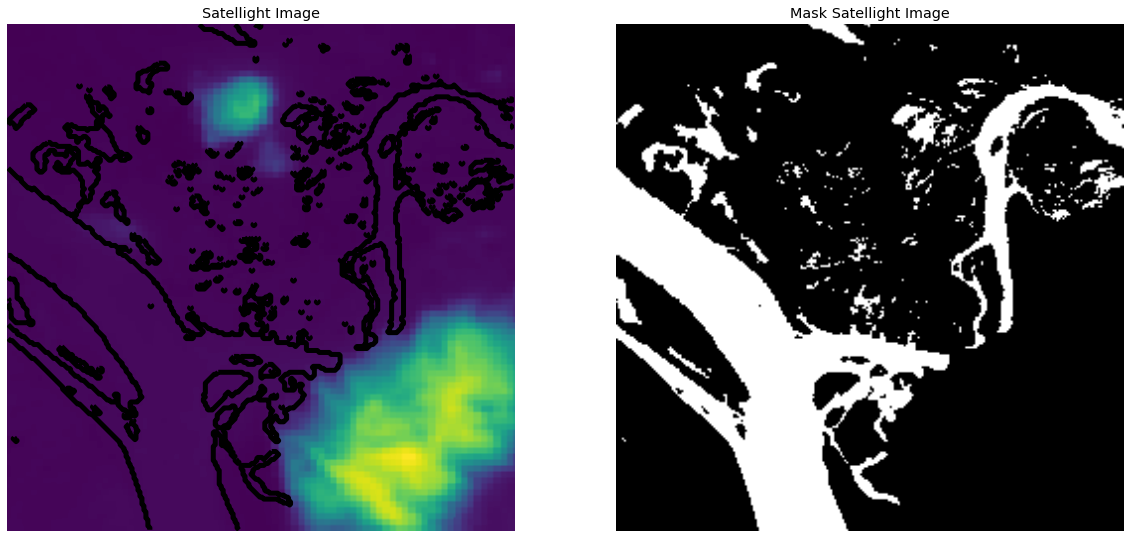

In [ ]:
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellight Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellight Image')
ax2.set_axis_off()

# Metrics

In [ ]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

# Generating loss function

In [ ]:

!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.9 MB/s 


In [ ]:
weights = [0.5,0.5]

In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [ ]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [ ]:
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
valset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [ ]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 6.8 MB/s 
     |████████████████████████████████| 1.6 MB 40.9 MB/s 


## Unet Block

In [ ]:
def conv2d_block(input_tensor, filters, kernel_size, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters , kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def Unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner
from tensorflow import keras

In [ ]:
h,w = 256,256

In [ ]:
input_img = Input((h, w, 13), name='img')

In [ ]:
input_img

<KerasTensor: shape=(None, 256, 256, 13) dtype=float32 (created by layer 'img')>

## Keras Autotuner Experiment

In [ ]:
def conv2d_block(input_tensor, filters, kernel_size, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters , kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def build_model(hp):
    c1 = conv2d_block(input_img,filters=hp.Int('conv_1_filter', min_value=8, max_value=16, step=4),
         kernel_size=hp.Choice('conv_1_kernel', values = [3,5]))
    # adding second convolutional layer 
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(hp.Float('dropout', 0, 0.5, step=0.1))(p1)

    c2 = conv2d_block(p1,filters=hp.Int('conv_2_filter', min_value=16, max_value=32, step=8),
         kernel_size=hp.Choice('conv_2_kernel', values = [3,5]))
    # adding second convolutional layer /
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(hp.Float('dropout', 0, 0.5, step=0.1))(p2)

    c3 = conv2d_block(p2,filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
         kernel_size=hp.Choice('conv_3_kernel', values = [3,5]))
    # adding second convolutional layer 
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(hp.Float('dropout', 0, 0.5, step=0.1))(p3)

    c4 = conv2d_block(p3, filters=hp.Int('conv_4_filter', min_value=64, max_value=128, step=32),
         kernel_size=hp.Choice('conv_4_kernel', values = [3,5]))
    # adding second convolutional layer 
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(hp.Float('dropout', 0, 0.5, step=0.1))(p4)

    c5 = conv2d_block(p4, filters=hp.Int('conv_5_filter', min_value=128, max_value=256, step=64),
         kernel_size=hp.Choice('conv_5_kernel', values = [3,5]))

    u6 = Conv2DTranspose(filters=hp.Int('conv_6_filter', min_value=64, max_value=128, step=32),
         kernel_size=hp.Choice('conv_6_kernel', values = [3,5]), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(hp.Float('dropout', 0, 0.5, step=0.1))(u6)
    c6 = conv2d_block(u6, filters=hp.Int('conv_6_filter', min_value=64, max_value=128, step=32),
                      kernel_size=hp.Choice('conv_6_kernel', values = [3,5]))


    u7 = Conv2DTranspose(filters=hp.Int('conv_7_filter', min_value=32, max_value=64, step=16),
         kernel_size=hp.Choice('conv_7_kernel', values = [3,5]), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(hp.Float('dropout', 0, 0.5, step=0.1))(u7)
    c7 = conv2d_block(u7, filters=hp.Int('conv_7_filter', min_value=32, max_value=64, step=16),
                      kernel_size=hp.Choice('conv_7_kernel', values = [3,5]))

    u8 = Conv2DTranspose(filters=hp.Int('conv_8_filter', min_value=16, max_value=32, step=8),
         kernel_size=hp.Choice('conv_8_kernel', values = [3,5]), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(hp.Float('dropout', 0, 0.5, step=0.1))(u8)
    c8 = conv2d_block(u8, filters=hp.Int('conv_8_filter', min_value=16, max_value=32, step=32),
                      kernel_size=hp.Choice('conv_8_kernel', values = [3,5]))

    u9 = Conv2DTranspose(filters=hp.Int('conv_9_filter', min_value=8, max_value=16, step=4),
         kernel_size=hp.Choice('conv_9_kernel', values = [3,5]), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(hp.Float('dropout', 0, 0.5, step=0.1))(u9)
    c9 = conv2d_block(u9, filters=hp.Int('conv_9_filter', min_value=4, max_value=8, step=4),
                      kernel_size=hp.Choice('conv_9_kernel', values = [3,5]))

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
              loss=total_loss,
              metrics=['accuracy',jaccard_coef])
    return model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 7.6 MB/s 
     |████████████████████████████████| 1.6 MB 55.9 MB/s 


In [ ]:
#importing random search
from kerastuner import RandomSearch
#creating randomsearch object

tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 3)
# search best parameter
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

ModuleNotFoundError: ignored

In [ ]:
h,w = 256,256

In [ ]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.1 MB 30 kB/s 
     |████████████████████████████████| 438 kB 67.9 MB/s 
     |████████████████████████████████| 1.7 MB 56.4 MB/s 
     |████████████████████████████████| 5.9 MB 56.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

In [ ]:
tf.__version__

'2.9.2'

In [ ]:
a[a==-1.0] = 0.0

In [ ]:
from keras import backend as  K
K.clear_session()

input_img = Input((h, w, 13), name='img')
model = Unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5),
           tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])]
#metrics_iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
#metrics_iou=[tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1], ignore_class =[-1])]
#metrics = ["accuracy", jaccard_coef]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics= metrics)
gc.collect()


4764

In [ ]:
metrics = ["accuracy", jaccard_coef]

In [ ]:
from keras import backend as  K
K.clear_session()

input_img = Input((h, w, 13), name='img')
model = Unet(input_img, n_filters=16, dropout=0.1, batchnorm=True)

In [ ]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=5e-4, verbose=1),
    ModelCheckpoint('model-Unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataResUnet.csv"),
    TensorBoard(log_dir='./logs')
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=16, epochs=15, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/15
26/26 [==============================] - ETA: 0s - loss: 0.8576 - accuracy: 0.8447 - jaccard_coef: 0.1771
Epoch 1: val_loss improved from inf to 0.89317, saving model to model-Unet.h5
26/26 [==============================] - 244s 9s/step - loss: 0.8576 - accuracy: 0.8447 - jaccard_coef: 0.1771 - val_loss: 0.8932 - val_accuracy: 0.9352 - val_jaccard_coef: 0.1261 - lr: 0.0010
Epoch 2/15
26/26 [==============================] - ETA: 0s - loss: 0.8020 - accuracy: 0.8872 - jaccard_coef: 0.2611
Epoch 2: val_loss improved from 0.89317 to 0.88563, saving model to model-Unet.h5
26/26 [==============================] - 233s 9s/step - loss: 0.8020 - accuracy: 0.8872 - jaccard_coef: 0.2611 - val_loss: 0.8856 - val_accuracy: 0.9188 - val_jaccard_coef: 0.1425 - lr: 0.0010
Epoch 3/15
26/26 [==============================] - ETA: 0s - loss: 0.7786 - accuracy: 0.8943 - jaccard_coef: 0.2907
Epoch 3: val_loss improved from 0.88563 to 0.88332, saving model to model-Unet.h5
26/26 [==============

KeyboardInterrupt: ignored

In [ ]:
history_a = results

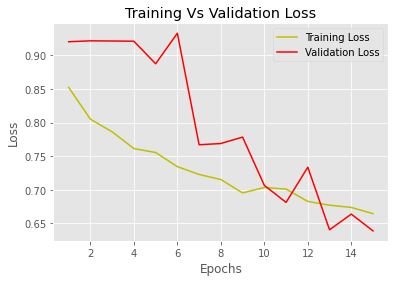

In [ ]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

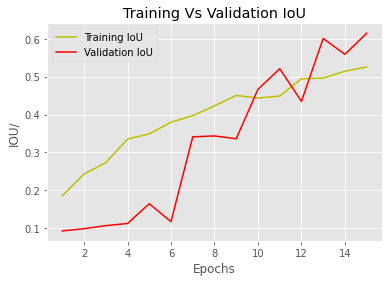

In [ ]:

jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IOU/")
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test, verbose=1)

2/2 [==============================] - 0s 112ms/step


In [ ]:
len(y_pred)

45

In [ ]:
y_pred_argmax = np.argmax(y_pred, axis=3)

NameError: ignored

In [ ]:
y_test_argmax = np.argmax(y_test, axis=3)

In [ ]:
len(y_pred_argmax)

45

In [ ]:
import random

In [ ]:
X_test.shape

(45, 256, 256, 13)

In [ ]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 19ms/step


TypeError: ignored

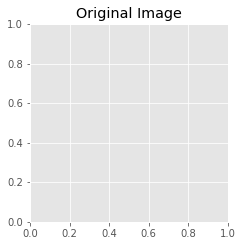

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image[:,:,0:].squeeze())
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image[2])
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

NameError: ignored

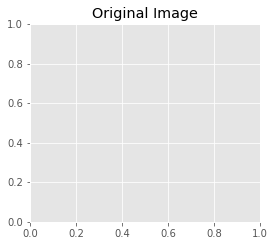

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image[0,:,:])
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,io_u,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,val_io_u,lr
16,0.124787,0.959963,0.971243,0.991255,0.995212,0.000000,0.102201,0.968342,0.983959,0.992656,0.998784,0.00000,0.001
18,0.121979,0.957391,0.970017,0.986894,0.995157,0.000000,0.103606,0.970161,0.984298,0.993281,0.998104,0.00000,0.001
19,0.126270,0.954717,0.968842,0.992440,0.994390,0.000000,0.110906,0.966247,0.985087,0.992757,0.998199,0.00000,0.001
13,0.139709,0.952280,0.963880,0.986624,0.996066,0.000000,0.112659,0.959867,0.980942,0.991436,0.998047,0.00000,0.001
14,0.141331,0.953166,0.967769,0.989560,0.993499,0.000000,0.126230,0.960223,0.982678,0.994115,0.997325,0.00000,0.001
12,0.144859,0.951009,0.966822,0.991390,0.991800,0.000000,0.129771,0.961092,0.982580,0.989315,0.998656,0.00000,0.001
15,0.136821,0.956097,0.963441,0.986504,0.993838,0.000000,0.129947,0.955177,0.985067,0.994249,0.997445,0.00000,0.001
17,0.133060,0.952268,0.968724,0.992636,0.993301,0.000000,0.144375,0.944879,0.972659,0.985696,0.994915,0.00000,0.001
10,0.154671,0.949920,0.967980,0.991512,0.992397,0.000004,0.155373,0.952781,0.969358,0.979195,0.998724,0.00000,0.001
11,0.143826,0.956329,0.969842,0.992938,0.995063,0.000000,0.179839,0.928794,0.973045,0.991053,0.995562,0.00000,0.001


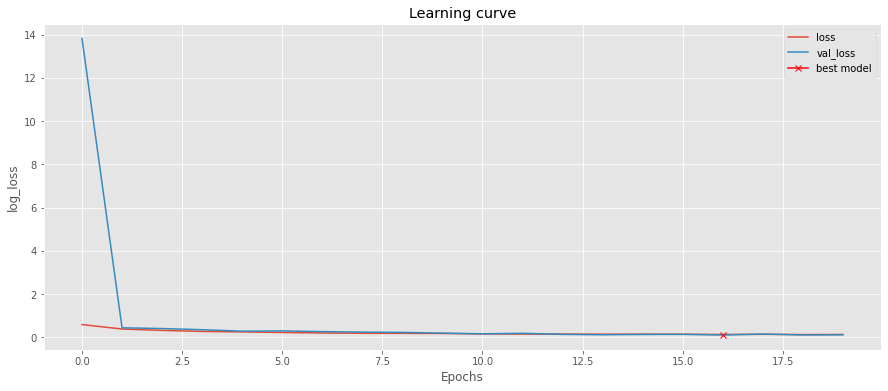

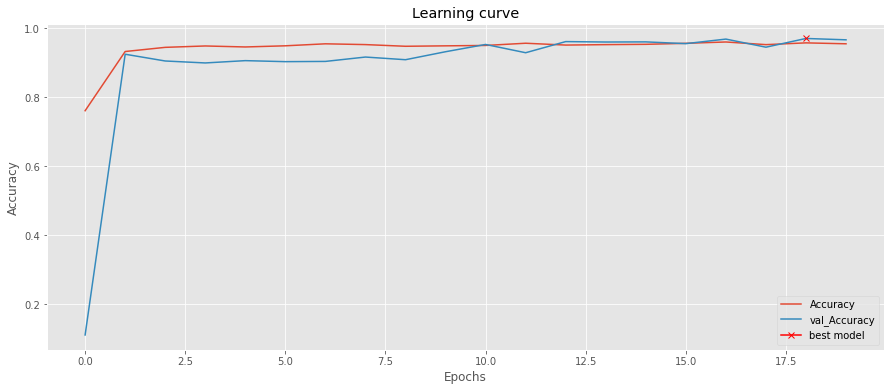

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [ ]:
model.load_weights('model-Unet.h5')

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

2/2 [==============================] - 0s 61ms/step - loss: 0.6962 - accuracy: 0.9079 - jaccard_coef: 0.4725


[0.6962080001831055, 0.9079030156135559, 0.4725204110145569]

In [ ]:
X_test.shape

(45, 256, 256, 13)

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

2/2 [==============================] - 0s 72ms/step


In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Satellight Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Satellight Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(),cmap='seismic', vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Satelight Image Predicted')
    ax[2].set_axis_off()
    
    ax[3].imshow(binary_preds[ix].squeeze() ,vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Satellight Mask Image Predicted binary');
    ax[3].set_axis_off()    

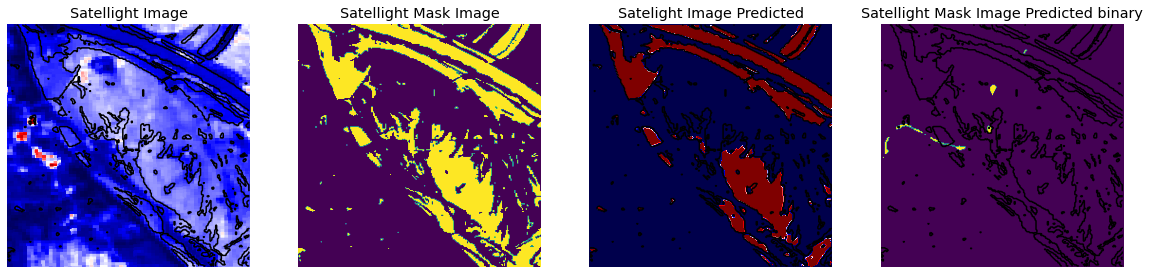

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train_t, preds_val_t, ix=2)

IndexError: ignored

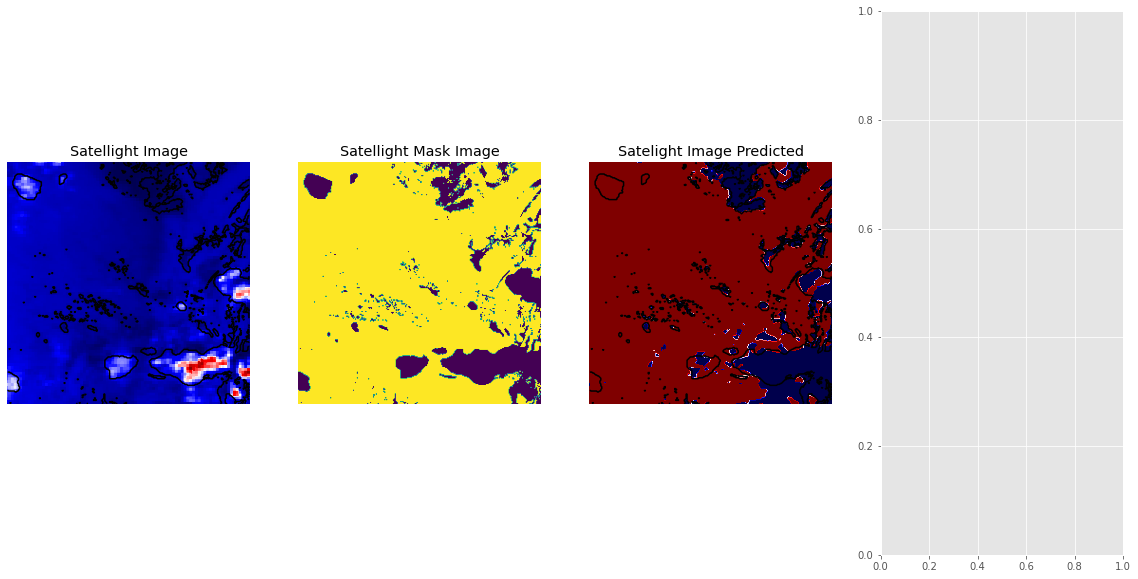

In [ ]:
plot_sample(X_train, y_train, preds_train_t, preds_val_t)

IndexError: ignored

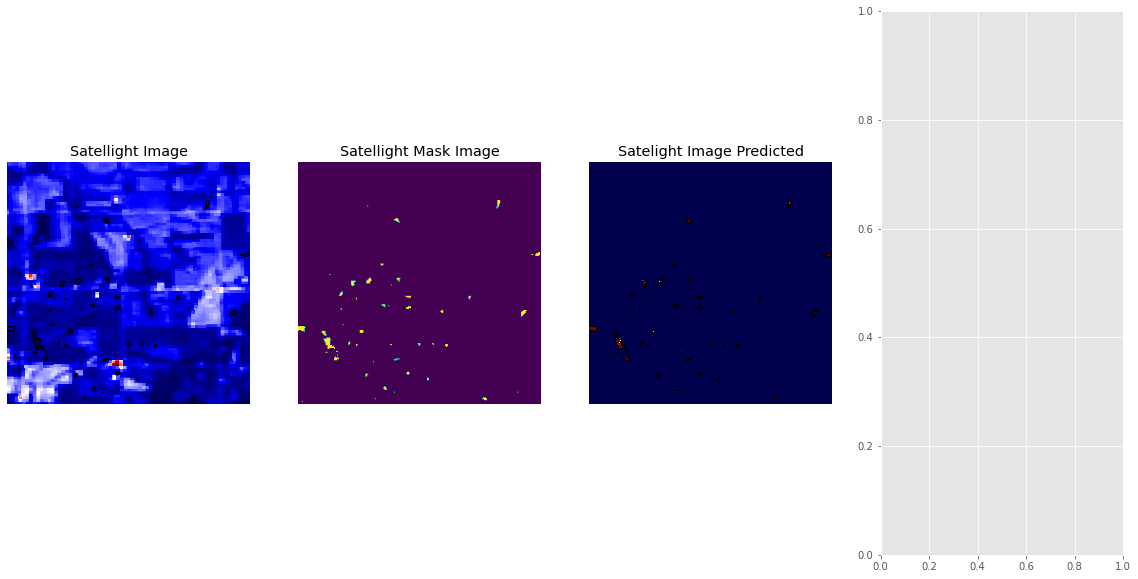

In [ ]:
plot_sample(X_train, y_train, preds_train_t, preds_val_t)

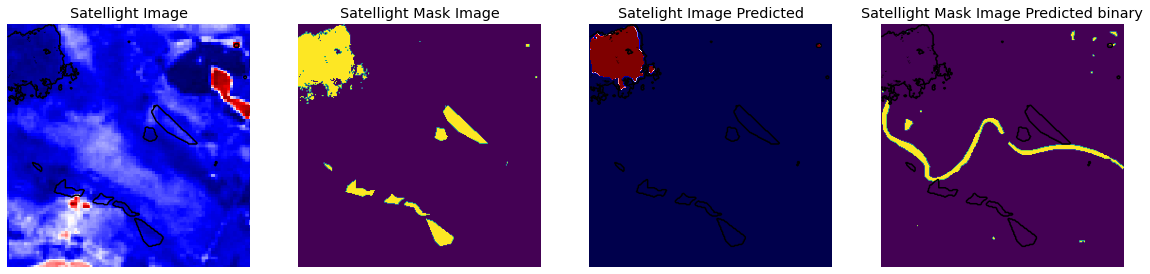

In [ ]:
plot_sample(X_train, y_train, preds_train_t, preds_val_t)

In [ ]:
y_preds

NameError: ignored

In [ ]:
test_img = rasterio.open('/content/Multispectral_MTD_MS_2.tif')

NameError: ignored

In [ ]:
profile = test_img.profile

In [ ]:
test_img_array = test_img.read()

In [ ]:
test_img_array = np.moveaxis(test_img_array,0,2)

In [ ]:
import cv2

In [ ]:
img = np.moveaxis(img, 0, 2)
  img_resize = cv2.resize(img, (w, h), interpolation = cv2.INTER_NEAREST)

In [ ]:
resized_test_img_array = cv2.resize(test_img_array, (256,256), interpolation = cv2.INTER_NEAREST)

In [ ]:
resized_test_img_array.shape

(256, 256, 13)

In [ ]:
txNew = np.reshape(resized_test_img_array, (1,256,256,13))

In [ ]:
txNew.shape

(1, 256, 256, 13)

In [ ]:
output = model.predict(txNew)

1/1 [==============================] - 0s 19ms/step


In [ ]:
output.shape

(1, 256, 256, 1)

In [ ]:
model.evaluate(txNew , output, verbose=1)

1/1 [==============================] - 1s 1s/step - loss: 2.1414e-05 - accuracy: 0.9986 - auc: 0.9994 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 1.0000 - io_u: 1.0000


[2.1413581634988077e-05, 0.9986114501953125, 0.9993815422058105, 1.0, 1.0, 1.0]

In [ ]:
img_resize = np.moveaxis(output, 2, 0)

In [ ]:
img_resize.shape

(256, 1, 256, 1)

In [ ]:
out_path = os.path('/content/drive')

TypeError: ignored

In [ ]:
with rasterio.open('/content/drive/MyDrive/Applied_ML/output.tif', 'w', **profile) as dst:
    dst.write(output)

ValueError: ignored